This notebook is new and experimental -- for closer-to-complete stuff, see the notebooks `experiments`, `q_learning_tests`, and `piaget_demo`.

In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.misc
import os
%matplotlib inline
import pdb

import re

import cPickle

import pyemd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from PIL import Image
import cv2

env_title = 'AssaultNoFrameskip-v3'
#env_title = 'BreakoutNoFrameskip-v4'
env = gym.make(env_title);

breakout = (env_title[:8] == 'Breakout')

if breakout:
    frame_h = 210
else:
    frame_h = 250

[2017-06-30 16:59:48,327] Making new env: AssaultNoFrameskip-v3


In [4]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Prototyper
from piaget import init_env, play

In [5]:
from nets import rewardNetwork, protoModelnetwork

In [6]:
def initial_obs(env, breakout=breakout):
    env.reset()
    if breakout:
        s, r, d, info = env.step(1) # request next ball in breakout
    else:
        s, r, d, info = env.step(np.random.randint(0,env.action_space.n))
    a = np.random.randint(0,env.action_space.n)
    s1, r1, d1, info1 = env.step(a)
    
    s_list = [s, s1]

    return s_list, r1, d1, info1, a

In [7]:
def processState(states):
    return np.reshape(states,[np.product(states.shape)])

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self,experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self,size,attention=False,rate=1):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,7])

In [9]:
n_steps = 5000

d = True

exp_buffer = experience_buffer()

for j in range(n_steps):
    if d:
        s_list, r, d, info, a = initial_obs(env, breakout)
        s_stack = np.dstack(s_list)
        s = processState(s_stack)

    old_a = a

    a = np.random.randint(0,env.action_space.n)
    s_next,r,d,info = env.step(a)

    s_list.pop(0)
    s_list.append(s_next)

    s_stack = np.dstack(s_list)
    s1 = processState(s_stack)

    exp_buffer.add(np.reshape(np.array([s,a,r,s1,d,old_a,0]),
                         [1,7])) #7th entry is loss if we are tracking it for every frame
    s = s1

In [10]:
r_frames = [b for b in exp_buffer.buffer if b[2] > 0]
n_frames = [b for b in exp_buffer.buffer if b[2] <= 0]

random.shuffle(n_frames)
random.shuffle(r_frames)

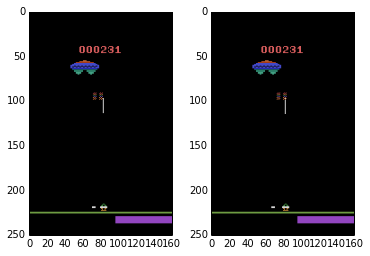

In [11]:
plt.figure()
plt.subplot(121)
plt.imshow(np.reshape(r_frames[0][3],(frame_h,160,6))[:,:,:3])
plt.subplot(122)
plt.imshow(np.reshape(r_frames[0][3],(frame_h,160,6))[:,:,3:])

protoModelNetwork

In [15]:
if breakout:
    game_id = 491930#447467
else:
    game_id = 619366
    
pt = Prototyper(game_id)

KeyboardInterrupt: 

0
0
(18, 34, 3)
3839.3839893


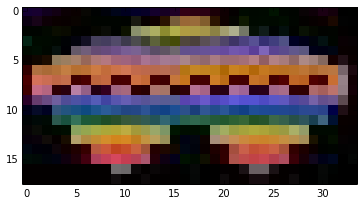

1
1
(3, 6, 3)
8130.92455418


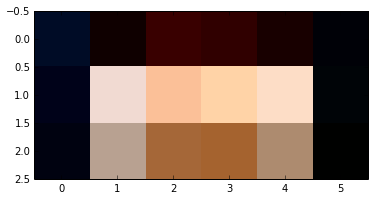

2
5
(10, 10, 3)
6404.31638889


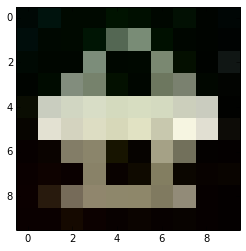

3
7
(10, 17, 3)
2380.78817378


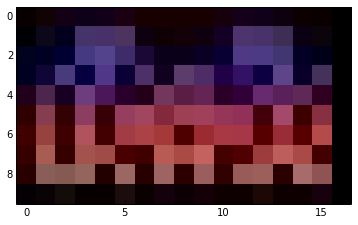

4
8
(10, 3, 3)
10378.2622222


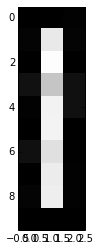

5
10
(4, 5, 3)
10625.21


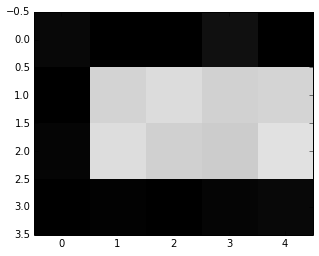

6
12
(7, 3, 3)
10623.5238095


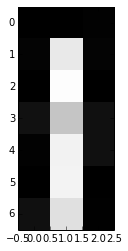

7
13
(4, 8, 3)
8557.296875


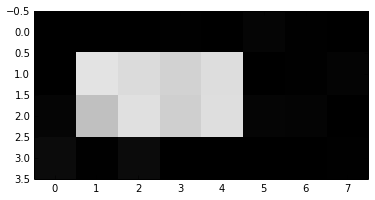

8
15
(7, 15, 3)
3189.75963719


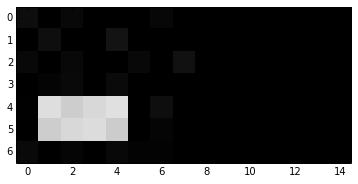

9
17
(3, 6, 3)
11499.1111111


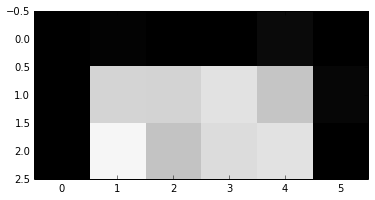

10
18
(10, 3, 3)
9481.72888889


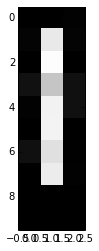

11
21
(167, 22, 3)
100.1082942


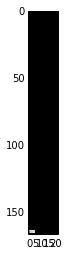

12
22
(108, 26, 3)
132.065445897


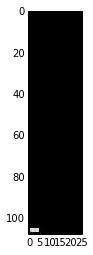

In [14]:
for i in range(len(pt.mover_ids)):
    m_id = pt.mover_ids[i]
    p = pt.mover_prototypes[i]
    plt.imshow(p,interpolation='nearest')
    print i
    print m_id
    print p.shape
    print np.var(p)
    plt.show()

In [166]:
tf.reset_default_graph()

pmn = protoModelnetwork(env, pt, 'pmn', n_free_kernels=0, frame_h=frame_h)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [187]:
cm_maxes = np.zeros((len(r_frames), 2*pmn.n_movers))
cd_maxes = np.zeros((len(r_frames), pmn.n_disps))

cm_maxes_n = np.zeros((len(r_frames), 2*pmn.n_movers))
cd_maxes_n = np.zeros((len(r_frames), pmn.n_disps))

In [188]:
for i, frame in enumerate(r_frames):

    cm = sess.run(pmn.conv_movers, feed_dict={pmn.scalarInput:np.expand_dims(frame[3],0)})
    cd = sess.run(pmn.conv_disps, feed_dict={pmn.scalarInput:np.expand_dims(frame[3],0)})
    
    for j, ch in enumerate(cm.T):
        cm_maxes[i,j] = np.max(ch)
    for j, ch in enumerate(cd.T):
        cd_maxes[i,j] = np.max(ch)
cdm_maxes = np.concatenate([cm_maxes, cd_maxes],1)

n_frames_comp = n_frames[:len(r_frames)]
for i, frame in enumerate(n_frames_comp):

    cm = sess.run(pmn.conv_movers, feed_dict={pmn.scalarInput:np.expand_dims(frame[3],0)})
    cd = sess.run(pmn.conv_disps, feed_dict={pmn.scalarInput:np.expand_dims(frame[3],0)})
    
    for j, ch in enumerate(cm.T):
        cm_maxes_n[i,j] = np.max(ch)
    for j, ch in enumerate(cd.T):
        cd_maxes_n[i,j] = np.max(ch)
cdm_maxes_n = np.concatenate([cm_maxes_n, cd_maxes_n],1)

In [174]:
print np.mean(cm_maxes,0)
print ''
print np.mean(cd_maxes,0)

[ 0.77777778  0.75        0.47222222  0.47222222  0.47222222  0.44444444
  0.          0.          0.25        0.22222222  0.36111111  0.
  0.47222222  0.47222222  0.44444444  0.          0.58333333  0.58333333
  0.5         0.5         0.          0.        ]

[ 0.05555556  0.          0.02777778  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.02777778  0.05555556  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.02777778  0.02777778  0.          0.          0.          0.
  0.05555556  0.          0.          0.          0.          0.
  0.05555556  0.16666667  0.          0.          0.          0.          0.
  0.

In [175]:
from itertools import combinations

for comb in combinations(range(cdm_maxes.shape[1]),2):
    if np.mean((cdm_maxes[:,comb[0]] + cdm_maxes[:,comb[1]]) > 0) > 0.9:
        print comb
        print np.mean((cdm_maxes[:,comb[0]] + cdm_maxes[:,comb[1]]) > 0)

(0, 16)
0.944444444444
(0, 17)
0.944444444444
(1, 16)
0.916666666667
(1, 17)
0.916666666667


In [139]:
n_clusters = 2

from sklearn.cluster import KMeans
km = KMeans(n_clusters=n_clusters)
cluster_assign = km.fit_predict(cdm_maxes)

clusters = []
for i in range(n_clusters):
    clusters.append(cdm_maxes[cluster_assign==i,:])

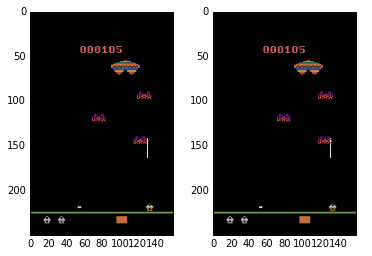

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [12]
 [13]
 [18]
 [19]
 [50]
 [76]]
FRAME 0
0


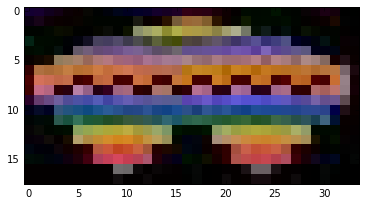

1


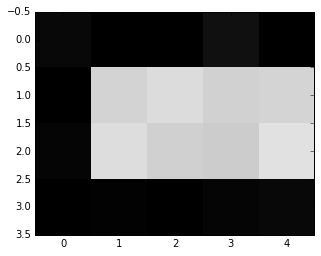

2


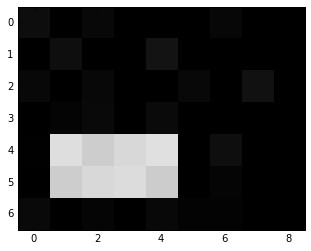

3


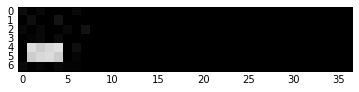

4


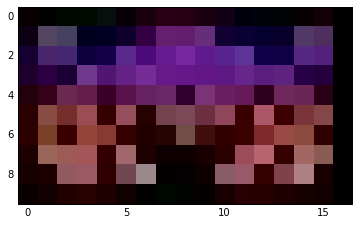

5


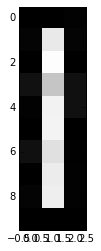

FRAME 1
1


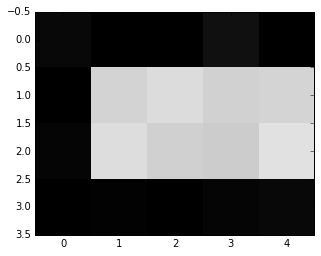

2


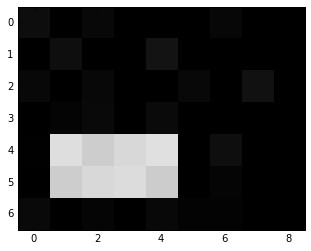

7


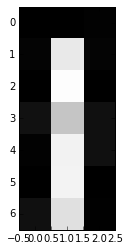

8


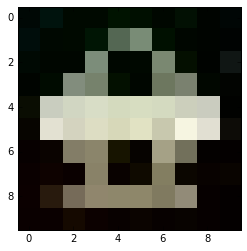

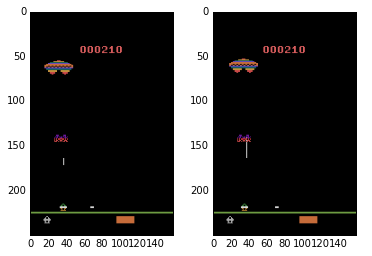

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [10]
 [12]
 [13]
 [14]
 [16]
 [17]
 [18]
 [19]
 [22]
 [51]
 [82]]
FRAME 0
0


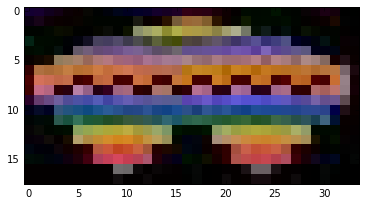

1


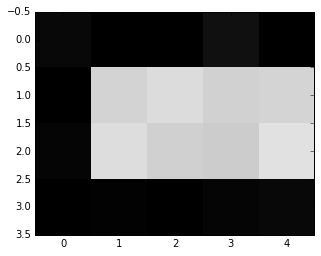

2


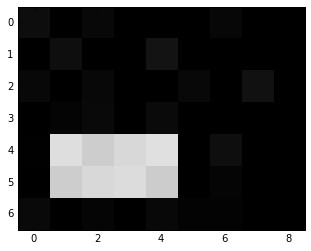

3


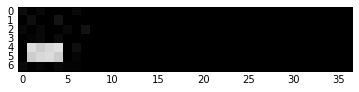

4


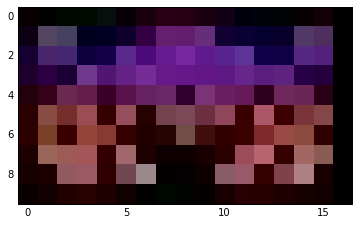

5


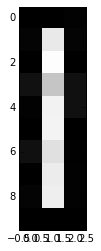

10


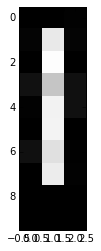

FRAME 1
1


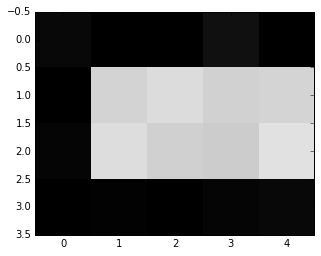

2


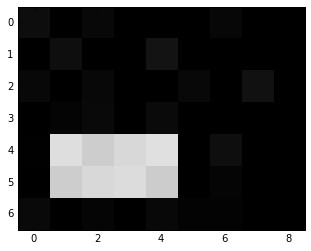

3


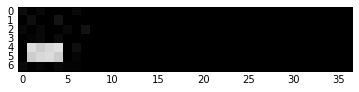

5


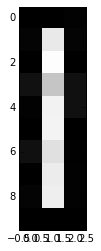

6


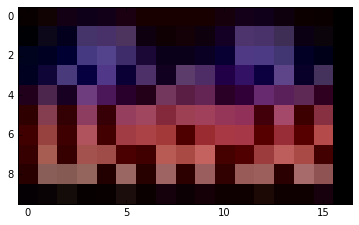

7


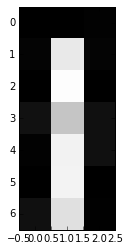

8


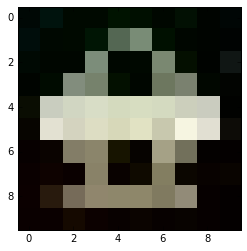

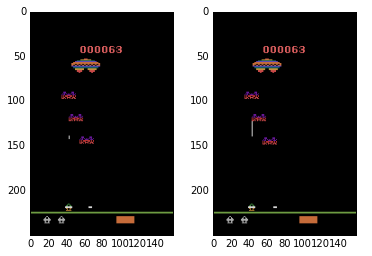

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [16]
 [17]
 [18]
 [19]
 [51]]
FRAME 0
0


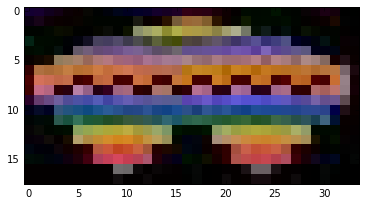

1


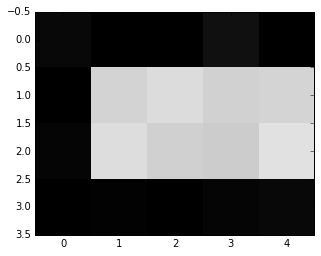

2


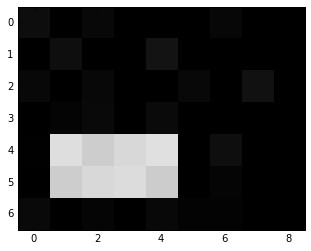

3


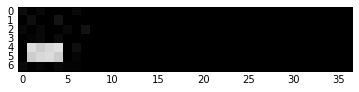

4


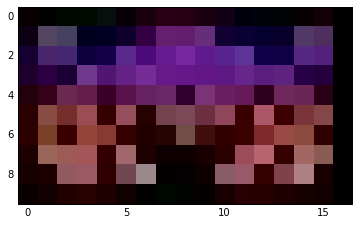

5


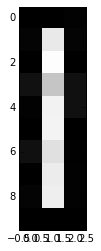

FRAME 1
5


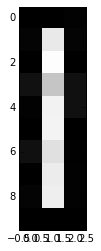

6


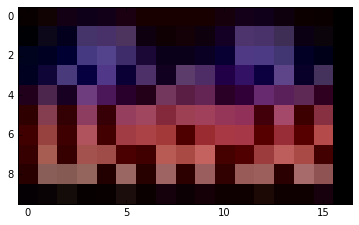

7


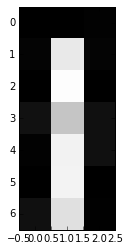

8


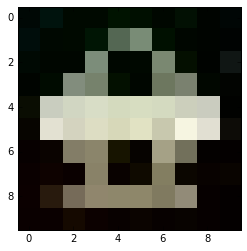

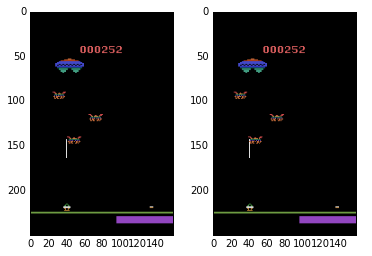

[[14]
 [16]
 [17]]
FRAME 0
FRAME 1
3


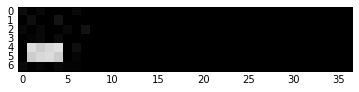

5


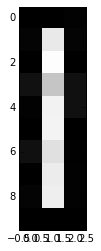

6


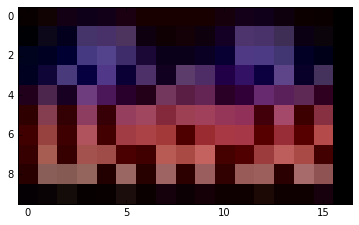

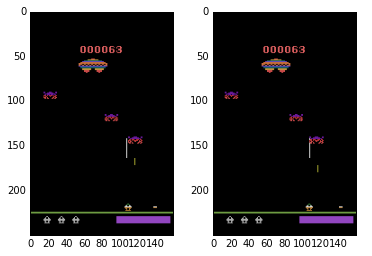

[[ 0]
 [ 1]
 [ 8]
 [ 9]
 [14]
 [70]
 [71]]
FRAME 0
0


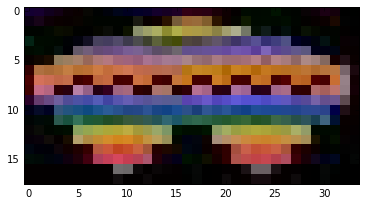

1


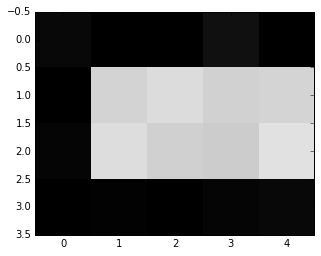

8


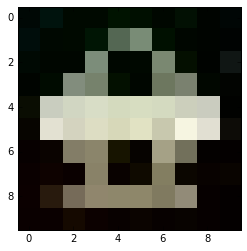

9


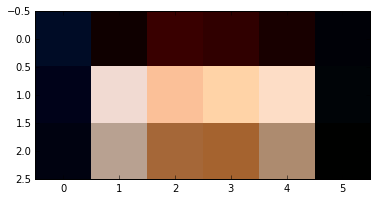

FRAME 1
3


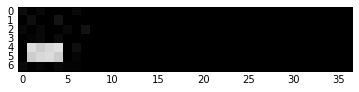

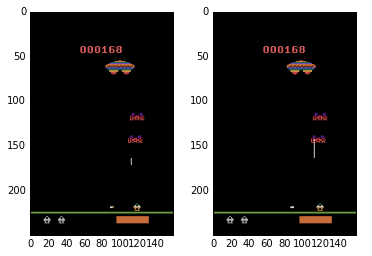

[[ 0]
 [ 1]
 [ 3]
 [ 5]
 [10]
 [14]
 [18]
 [19]
 [99]]
FRAME 0
0


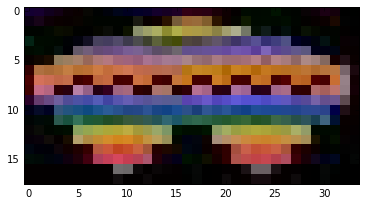

1


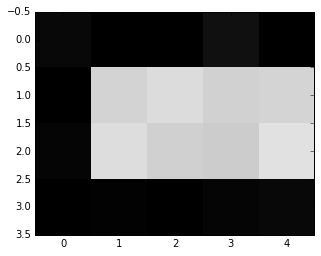

3


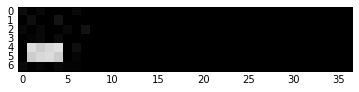

5


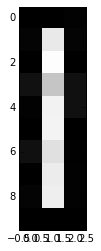

10


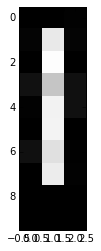

FRAME 1
3


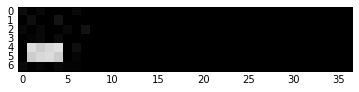

7


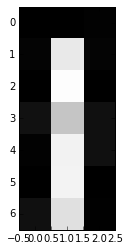

8


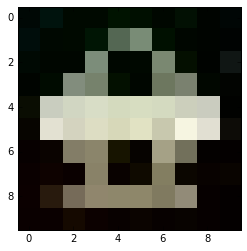

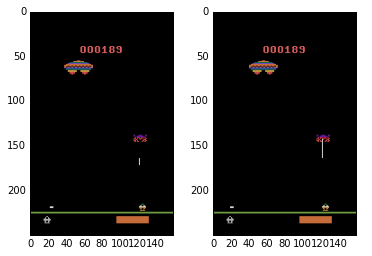

[[ 0]
 [ 1]
 [ 2]
 [ 3]
 [ 4]
 [ 5]
 [ 8]
 [ 9]
 [10]
 [14]
 [18]
 [19]
 [99]]
FRAME 0
0


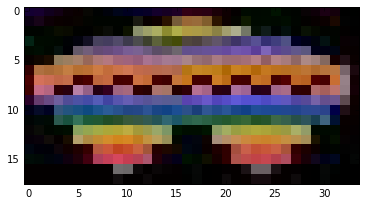

1


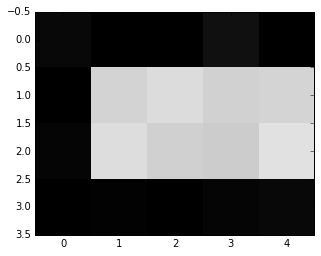

2


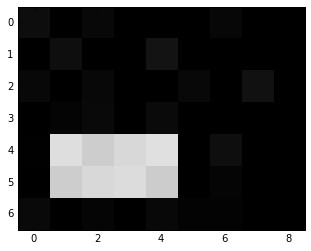

3


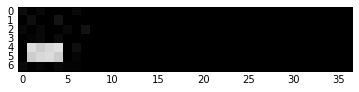

4


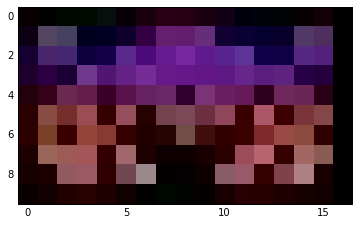

5


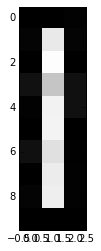

8


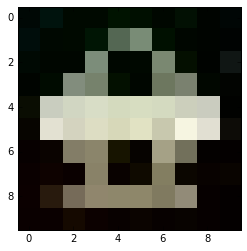

9


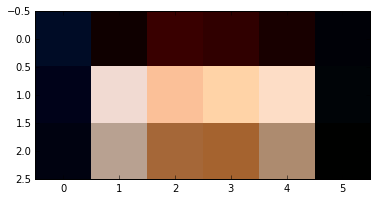

10


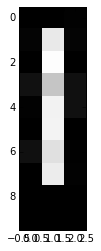

FRAME 1
3


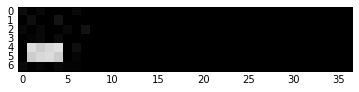

7


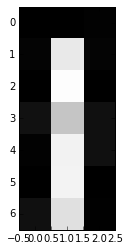

8


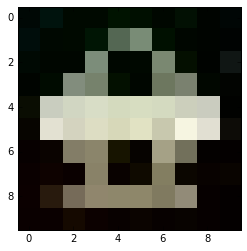

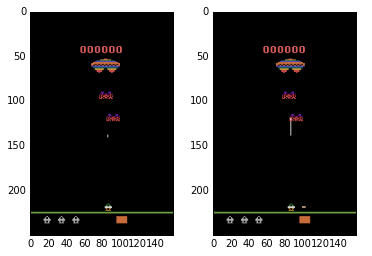

[[ 0]
 [ 1]
 [12]
 [13]
 [16]
 [17]]
FRAME 0
0


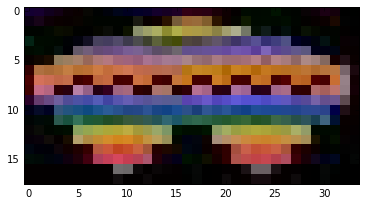

1


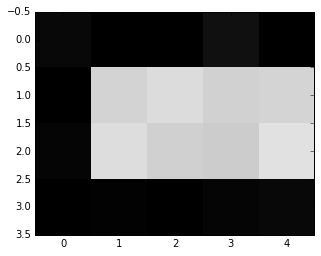

FRAME 1
1


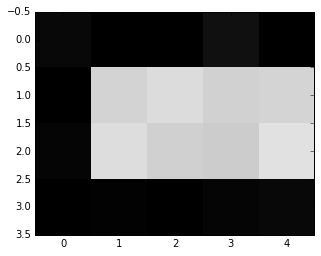

2


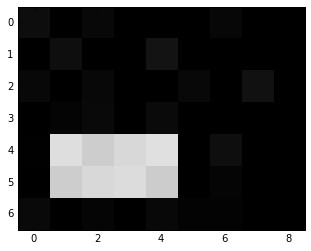

5


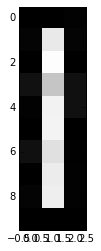

6


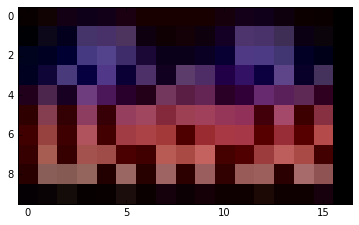

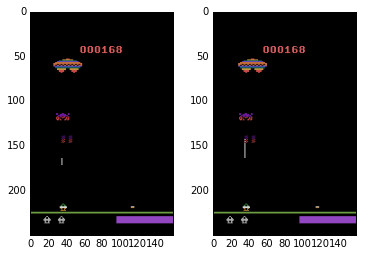

[[ 0]
 [ 1]
 [ 8]
 [ 9]
 [10]
 [14]
 [16]
 [17]]
FRAME 0
0


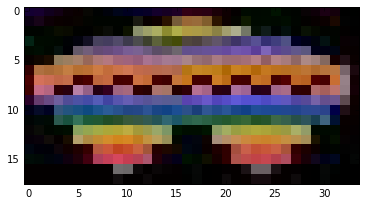

1


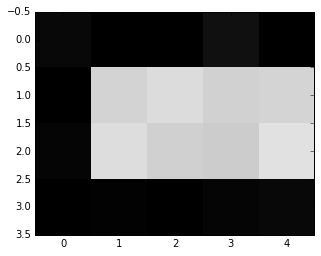

8


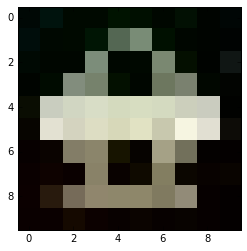

9


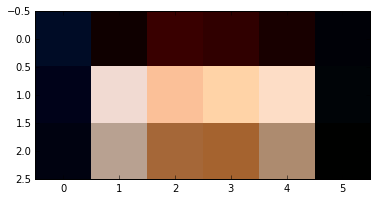

10


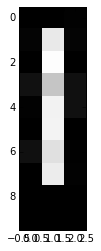

FRAME 1
3


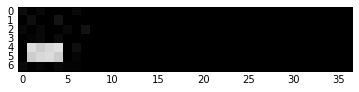

5


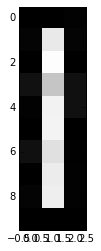

6


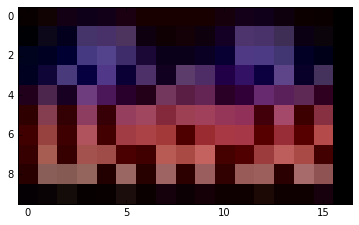

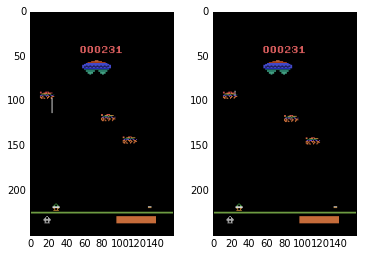

[[16]
 [17]]
FRAME 0
FRAME 1
5


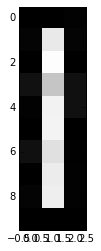

6


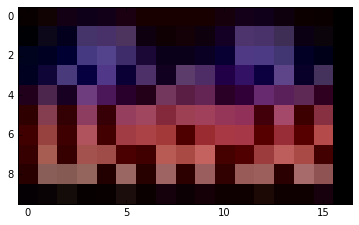

In [184]:
for i, frame in enumerate(r_frames[:10]):
    plt.figure()
    plt.subplot(121)
    plt.imshow(np.reshape(frame[3],(frame_h,160,6))[:,:,:3])
    plt.subplot(122)
    plt.imshow(np.reshape(frame[3],(frame_h,160,6))[:,:,3:])
    plt.show()

    print np.argwhere(cdm_maxes[i,:]>0)
    print 'FRAME 0'
    for j in range(len(pt.mover_prototypes)):
        if cdm_maxes[i,j] > 0:
            p = pt.mover_prototypes[j]
            plt.imshow(p,interpolation='nearest')
            print j
            plt.show()
    print 'FRAME 1'
    for j in range(len(pt.mover_prototypes),2*len(pt.mover_prototypes)):
        if cdm_maxes[i,j] > 0:
            p = pt.mover_prototypes[j-len(pt.mover_prototypes)]
            plt.imshow(p,interpolation='nearest')
            print j-len(pt.mover_prototypes)
            plt.show()

In [75]:
cm_maxes_0 = cm_maxes[(cm_maxes[:,2]>0),:]
cd_maxes_0 = cd_maxes[(cm_maxes[:,2]>0),:]

r_frames_0 = [r_frames[i] for i in range(len(r_frames)) if cm_maxes[i,2]>0]

rewardNetwork

In [89]:
rn = rewardNetwork(env, 'rn')

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [276]:
batch_size = 32
steps = 50
avg_window = batch_size*10
frame_err_list = []

10
20
30
40
50


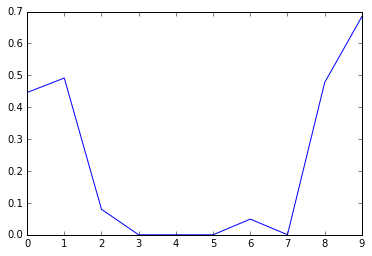

In [278]:
n_updates = 0
while n_updates < steps:
    train_batch = exp_buffer.sample(batch_size)
    losses = sess.run(rn.batch_losses, feed_dict={rn.scalarInput:np.vstack(train_batch[:,0]), rn.target:train_batch[:,2]})
    if max(losses) > 0:
        frame_err_list.extend(losses)
        sess.run(rn.updateModel, feed_dict={rn.scalarInput:np.vstack(train_batch[:,0]), rn.target:train_batch[:,2]})
        
        n_updates += 1
        if n_updates % 10 == 0:
            print n_updates
err_mat = np.resize(frame_err_list,[len(frame_err_list)//avg_window,
                                               avg_window])
avg_errs = np.average(err_mat,1)
plt.plot(avg_errs)
plt.show()